# <center> Housing Price Prediction </center>

# Overview:


- #### **The Data**
    - This datasets contains features for ~ 23k houses in Kings County in Seattle, Washington
    - These features include sale price, number of bed/bathrooms, living/lot square footage, condition/grade, age, and location
- #### **The Goal**
    - The end goal is to predict the sale price of a home given the other features using Linear Regression
    - The focus of this project will not be on advanced modelling techniques nor hyperparameter tuning, but instead on....
        - Handling NaNs, Duplicates, Dtypes
        - Data Cleaning
        - Exploratory Data Analysis
        - Feature Engineering
        - Understanding the output of the linear regression model for decision making

# Notebook Outline

- #### **Part 1: Cleaning and EDA**
    - Handle duplicates, NaN's, dtypes, and minimal feature engineering
    - Each feature's distribution is viewed as its relationship with our dependent variable
- #### **Part 2: Feature Engineering and EDA:**
    - Create new features from the original features
    - View distributions and relationship with dependent variable
- #### **Part 3: Modelling and Evaluation**
    - Determine which model was the most successful in prediction
    - Determine which methods were most impactful on model performance (feature engineering vs transforming etc)

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center><u> Part 1: Data Cleaning </u></center>

### Import Packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import branca.colormap as cm
from scipy import stats
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
warnings.simplefilter(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Define custom functions

In [2]:
def hist_box(data, xlabel = None, title = None, font_scale=2, figsize=(9,8), bins = None, x_lim = []):
    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(data, ax=ax_box2)
    sns.distplot(data, ax=ax_hist2, bins=bins) if bins else sns.distplot(data, ax=ax_hist2)
    ax_hist2.ticklabel_format(useOffset=False, style='plain')
    if x_lim != []:
        ax_hist2.set_xlim(x_lim[0],x_lim[1])
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

### Import Data and Inspect

In [3]:
# Import .csv file into DataFrame
df = pd.read_csv(r'kc_house_data.csv')

# Rename columns and index for interpretability
new_names = {'id':'sale_id','date':'sale_date','price':'sale_price','view':'has_been_viewed','sqft_above':'sqft_no_basement',
             'sqft_living15':'sqft_living_15_nn','sqft_lot15':'sqft_lot_15_nn'}

df.rename(columns = new_names, inplace=True)
df.index.name = 'unique_id'

# View sample of DataFrame
display(df.shape)
df.sample(2)

(21597, 21)

sale_id sale_date  sale_price  bedrooms  bathrooms  sqft_living  \
unique_id                                                                       
2294       2979800520  6/3/2014 605000.0000         5     2.7500         2740   
9213       2140900100  2/3/2015 289000.0000         4     2.5000         1961   

           sqft_lot  floors  waterfront  has_been_viewed  condition  grade  \
unique_id                                                                    
2294           5616  1.5000      0.0000           0.0000          5      7   
9213           3207  2.0000      0.0000           0.0000          3      7   

           sqft_no_basement sqft_basement  yr_built  yr_renovated  zipcode  \
unique_id                                                                    
2294                   1670        1070.0      1925        0.0000    98115   
9213                   1961           0.0      2006        0.0000    98042   

              lat      long  sqft_living_15_nn  sqft_lot_15_nn  
unique_id                                                       
2294      47.6866 -122.3170               1600            4592  
9213      47.3507 -122.1600               1961            3401

# <center> ----------------------------------------------------------------------------------------------------------- </center>

# Duplicates and Missing Data

## Duplicates
- The `sale_id` column does have duplicates, but they appear to be unique sales for the same house

In [4]:
df['sale_id'].duplicated().value_counts()

False    21420
True       177
Name: sale_id, dtype: int64

In [5]:
df.duplicated().value_counts()

False    21597
dtype: int64

## Missing Data

In [6]:
df_nans = pd.DataFrame()
df_nans['Count'] = df.isna().sum()
df_nans['Percent'] = round(df.isna().mean()*100,1)
df_nans[df_nans['Count'] > 0]

Count  Percent
waterfront        2376  11.0000
has_been_viewed     63   0.3000
yr_renovated      3842  17.8000

In [7]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
20.0          1
2120.0        1
2500.0        1
274.0         1
2580.0        1
Name: sqft_basement, Length: 304, dtype: int64

### The following columns are missing data
- **`waterfront`** :
    - This could be fixed by looking at a map view
    - On average ~ 0.05% of houses are waterfront, so that would mean hand picking only ~12 houses, the rest can be labeled 0
- **`has_been_viewed`** : 
    - This is such a small subset its likely okay to just drop
    - Most houses in this dataset have not been viewed at all, could likely impute with 0
- **`yr_renovated`** : 
    - 96% of homes have not been renovated, so filling with 0 is likely appropriate
- **`sqft_basement`** 
    - Wrong dtype, "?"'s are to be treated as NaNs
    - Most houses have no basement, likely okay to fill with 0

#### Waterfront Map
- Plot houses missing `waterfront` data

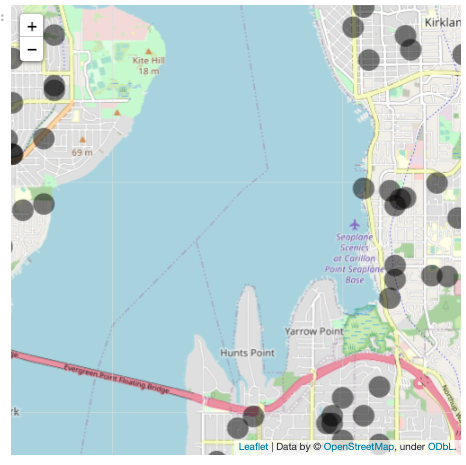

In [8]:
# Get hand picked list
actually_waterfront = [3577000116,1568100920,2726049034,3761700053,825059178,7129303070,2579500110,1724069060,9201300020,573000685]

# Use list to fill with 1s, then fill the rest with 0s
df.loc[df['sale_id'].isin(actually_waterfront), 'waterfront'] = 1
df['waterfront'] = df['waterfront'].fillna(0)

In [9]:
# Fill with 0s
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [10]:
# Replace "?" with nan
df['sqft_basement'].replace("?", 0, inplace = True)

df['sqft_basement'] = df['sqft_basement'].astype(float)

# Drop NaNs
df = df.dropna()

# <center> ----------------------------------------------------------------------------------------------------------- </center>

# Data Cleaning & EDA

## 1) Sale Price: 
- Target/Dependent Variable
- Strong Positive Skew

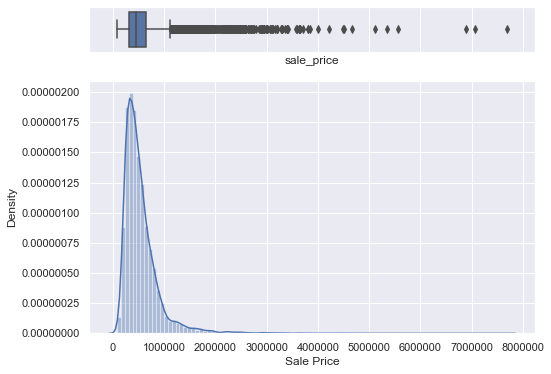

In [11]:
hist_box(df['sale_price'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
         xlabel="Sale Price", 
        )

## 2) Sale Date: 
- Cast to proper data type
- Extract year/month

In [12]:
# Convert to dt
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Get month & year together
df['sale_date_monthly'] = df['sale_date'].dt.to_period('M')

# Get year
df['sale_year'] = df['sale_date'].dt.year

# Get month
df['sale_month'] = df['sale_date'].dt.month

- View stats by month

In [13]:
date_df = pd.DataFrame()
date_df['num_sales'] = df.groupby('sale_date_monthly')['sale_id'].count()
date_df['mean_sale_price'] = df.groupby('sale_date_monthly')['sale_price'].mean().astype(int)
date_df['n_days'] = df.groupby('sale_date_monthly')['sale_date'].nunique()
date_df

num_sales  mean_sale_price  n_days
sale_date_monthly                                    
2014-05                 1762           547092      30
2014-06                 2177           556903      30
2014-07                 2210           545044      31
2014-08                 1933           536648      31
2014-09                 1764           530009      30
2014-10                 1871           539306      31
2014-11                 1407           522270      29
2014-12                 1464           524744      29
2015-01                  972           526016      26
2015-02                 1243           509268      26
2015-03                 1867           544303      31
2015-04                 2218           560504      30
2015-05                  646           558193      17

- There appears to be a positive linear relationship between the number of houses sold in a month and the mean sale price
    - There is one strong outlier (641), however this month has incomplete data

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


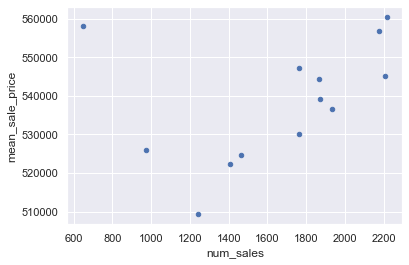

In [14]:
date_df.plot.scatter(x='num_sales',y='mean_sale_price');

- There appears to be a trend in sale price by month
    - Peak = summer
    - Trough = winter

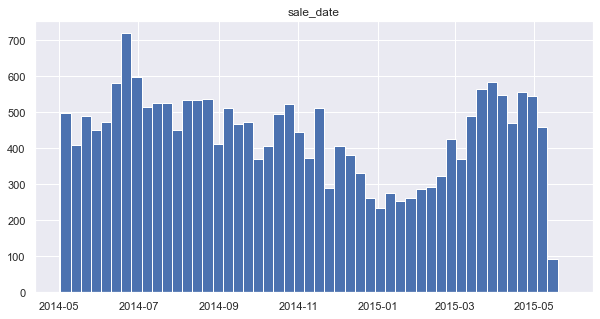

In [15]:
df.hist('sale_date', bins=50, figsize = (10,5));

- These are interesting relationships, it may be the case that:
    - The housing market has seasonality which drives up demand in the summer
    - This increased demand leads to higher sale prices
- Providing this data to our model will likely lead to better results

## 5) Sqft Living: 
- Most houses have less than 4,500 sqft
- Positive Skew

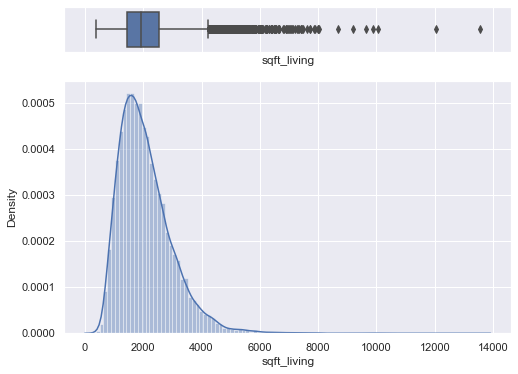

In [16]:
hist_box(df['sqft_living'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- There appears to be a positive relationship between living sqft and sale price


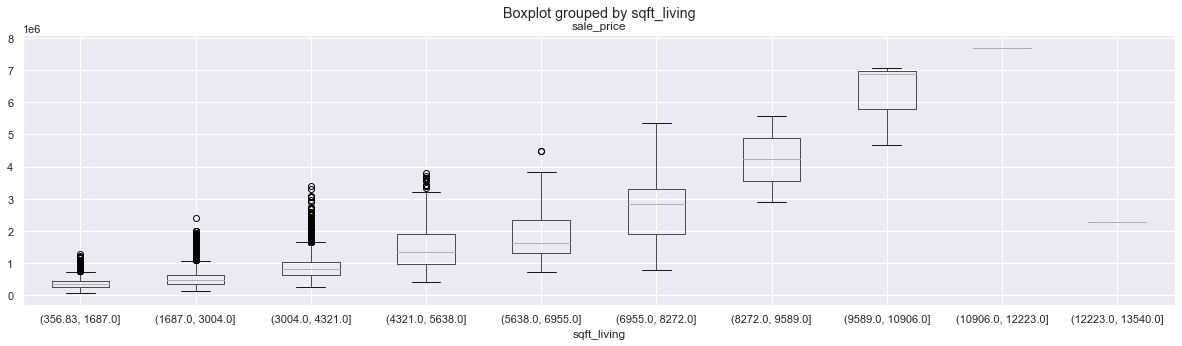

In [17]:
df_temp = df[['sale_price','sqft_living']]
df_temp['sqft_living'] = pd.cut(df['sqft_living'], bins=10)
df_temp[['sale_price','sqft_living']].boxplot('sale_price', 
                                                by='sqft_living', 
                                                figsize=(20,5)
                                                );

## 7) Waterfront: 
- Most houses are not waterfront

In [18]:
df['waterfront'].value_counts(normalize=True)

0.0000   0.9928
1.0000   0.0072
Name: waterfront, dtype: float64

- Waterfront houses do appear to have a higher sale price!

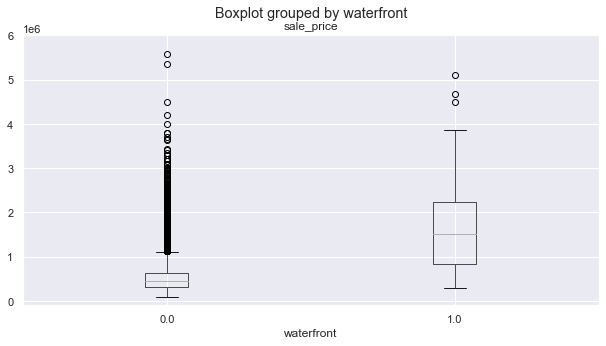

In [19]:
df[['sale_price','waterfront']].boxplot('sale_price', 
                                      by='waterfront', 
                                      figsize=(10,5)
                                     ).set_ylim(-100000,6000000);

## 8) Has Been Viewed: 
- Most houses have not been viewed at all

In [20]:
df['has_been_viewed'].value_counts(normalize=True)

0.0000   0.9019
2.0000   0.0444
3.0000   0.0236
1.0000   0.0153
4.0000   0.0147
Name: has_been_viewed, dtype: float64

- Houses that have been viewed more often times have a higher sale price
- Why?
    - This might hint at quality (higher quality houses will get viewed more)
    - This might also hint at demand (houses with multiple offers will sell for more)

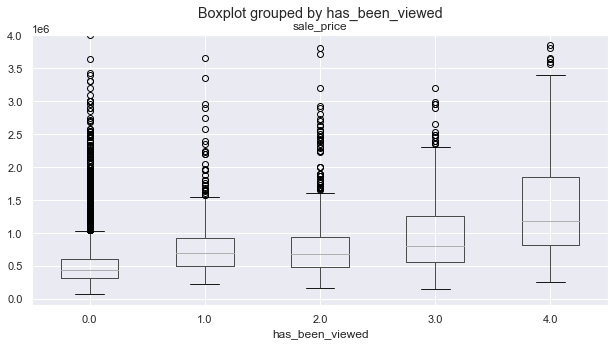

In [21]:
df[['sale_price','has_been_viewed']].boxplot('sale_price', 
                                              by='has_been_viewed', 
                                              figsize=(10,5)
                                             ).set_ylim(-100000,4000000);

## 10) Grade: 
- Most houses have a grade between 6 and 9

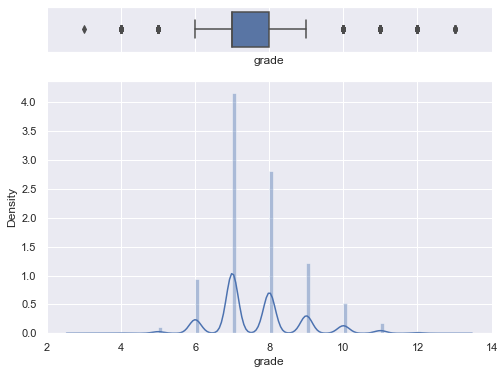

In [22]:
hist_box(df['grade'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Grade appears to have a strong positive relationship with sale price

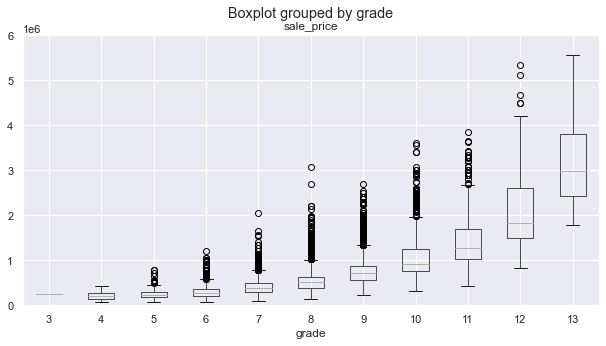

In [23]:
df[['sale_price','grade']].boxplot('sale_price', 
                                      by='grade', 
                                      figsize=(10,5)
                                     ).set_ylim(0,6000000);

## 12) Sqft Basement: 
- Most houses don't have a basement

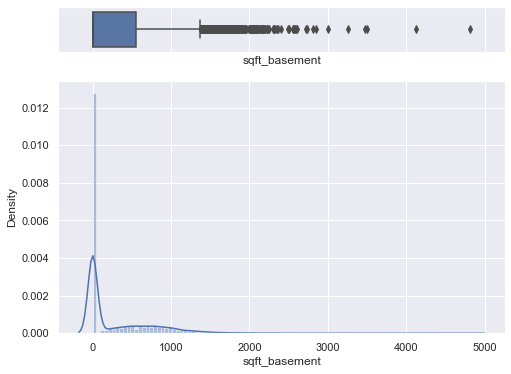

In [24]:
hist_box(df['sqft_basement'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Houses with basements tend to have have higher sale prices

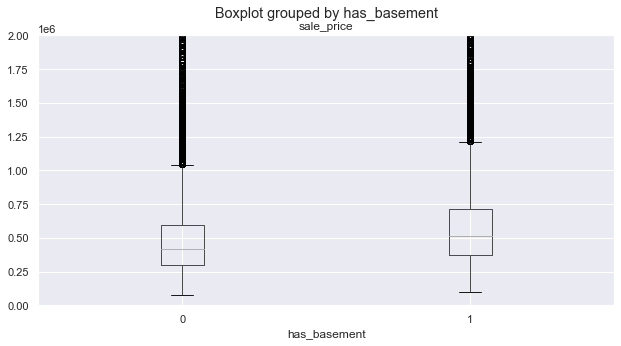

In [25]:
df_temp = df[['sale_price','sqft_basement']]
df_temp['has_basement'] = 0
df_temp.loc[df_temp['sqft_basement'] > 0, 'has_basement'] = 1
df_temp.boxplot('sale_price', 
                by='has_basement', 
                figsize=(10,5)
                ).set_ylim(-1,2000000);

- For houses that have basements, larger basements translate to higher sale prices

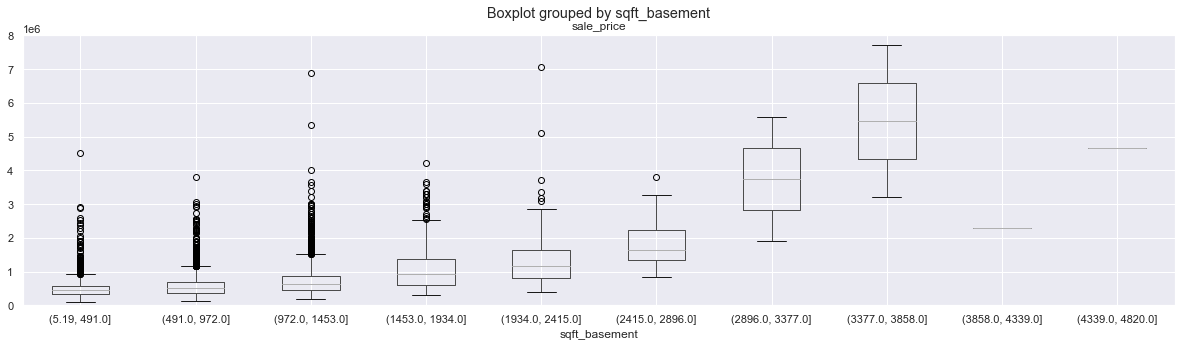

In [26]:
df_temp = df[df['sqft_basement'] > 0][['sale_price','sqft_basement']]
df_temp['sqft_basement'] = pd.cut(df_temp['sqft_basement'], bins=10)
df_temp[['sale_price','sqft_basement']].boxplot('sale_price', 
                                                by='sqft_basement', 
                                                figsize=(20,5)
                                                ).set_ylim(-1,8000000);

## 13) Year Built: 
- Most houses were built between 1960 and 2000

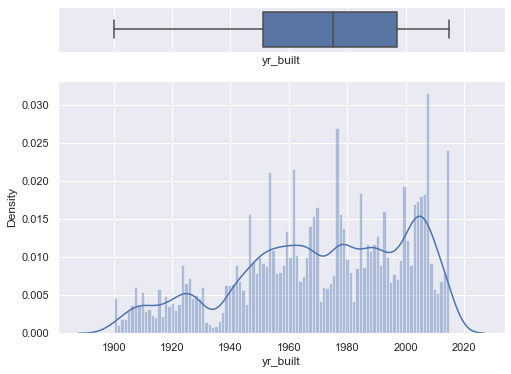

In [27]:
hist_box(df['yr_built'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- Interestingly enough, there is not a strong relationship between the year built and the sale price
- Why?
    - The houses built bewteen 1928 and 1986 may have other less favorable characteristics (smaller, lower grade)
    - Its also possible that the older homes (< 1920) have been remodelled, reversing the trend

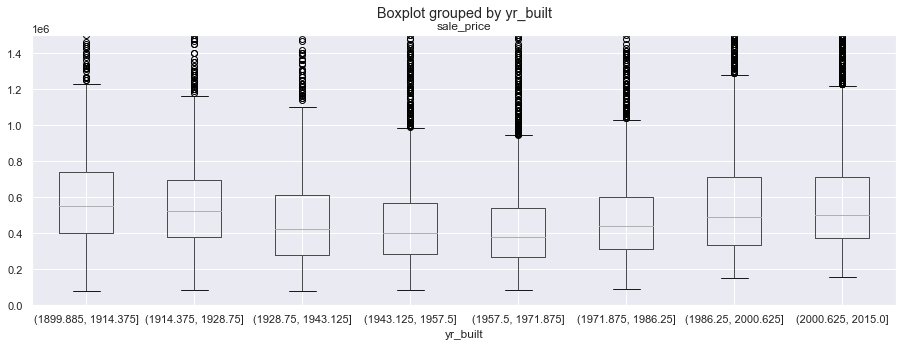

In [28]:
df_temp = df[['sale_price','yr_built']]
df_temp['yr_built'] = pd.cut(df['yr_built'], bins=8)
df_temp[['sale_price','yr_built']].boxplot('sale_price', 
                                            by='yr_built', 
                                            figsize=(15,5)
                                            ).set_ylim(-1,1500000);

## 14) Year Renovated: 
- For homes that were renovated, most were done between 1990 and 2005

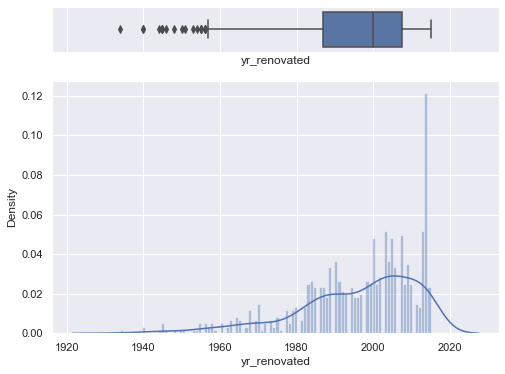

In [29]:
hist_box(df[df['yr_renovated'] > 0]['yr_renovated'], 
         figsize=(8,6), 
         bins = 100, 
         font_scale=1, 
        )

- For houses that were renovated, those that were worked on more recently tended to have higher sale prices

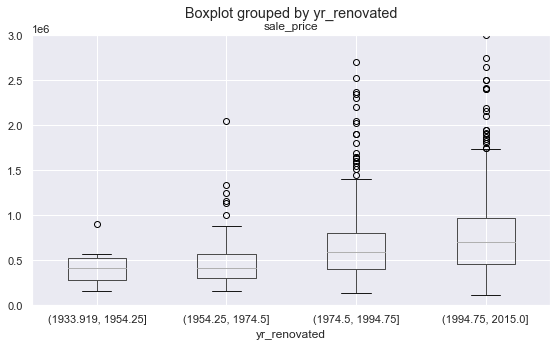

In [30]:
df_temp = df[df['yr_renovated'] > 0][['sale_price','yr_renovated']]
df_temp['yr_renovated'] = pd.cut(df_temp['yr_renovated'], bins=4)
df_temp[['sale_price','yr_renovated']].boxplot('sale_price', 
                                                by='yr_renovated', 
                                                figsize=(9,5)
                                                ).set_ylim(-1,3000000);

- Engineer features "years since last update"
    - For houses with no renovation, its the age of the house
    - For houses with a renovation, its the age of the renovation

In [31]:
df['years_since_update'] = 2022 - df['yr_built']
df.loc[df['yr_renovated'] > 0, 'years_since_update'] = 2022 - df['yr_renovated']

- Interestingly enough, the odd trend seen in year built appears here as well
    - This makes me believe there are confounding variables with houses built a long time ago (location, grade, etc)

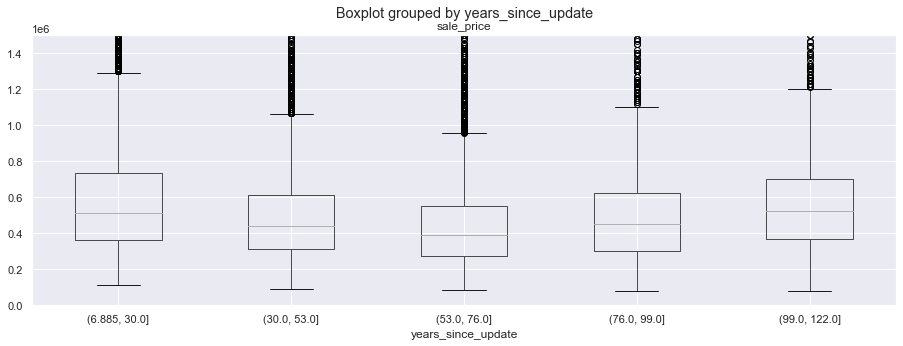

In [32]:
df_temp = df[['sale_price','years_since_update']]
df_temp['years_since_update'] = pd.cut(df_temp['years_since_update'], bins=5)
df_temp[['sale_price','years_since_update']].boxplot('sale_price', 
                                                by='years_since_update', 
                                                figsize=(15,5)
                                                ).set_ylim(-1,1500000);

## 15) Zipcode: 
- There are 70 different zipcodes in this dataset

In [33]:
df['zipcode'].nunique()

70

- Get the number of houses and mean sale price within the zipcode
- Sort, then view every ***n*** to see if they differ meaningfully

In [34]:
zip_df = pd.DataFrame()
zip_df['num_houses'] = df.groupby('zipcode')['sale_id'].count()
zip_df['mean_sale_price'] = df.groupby('zipcode')['sale_price'].mean().astype(int)
zip_df = zip_df.sort_values('mean_sale_price', ascending=False)
zip_df.iloc[::7, :]

num_houses  mean_sale_price
zipcode                             
98039            50          2161300
98006           497           860139
98077           198           682885
98007           141           617254
98107           266           579109
98011           194           489671
98126           353           424827
98038           586           367011
98042           545           311666
98188           136           289078

- Showing a map view of houses colored by the mean sale price in their zip
- From a map view it becomes very clear that zipcodes contain a lot of information 

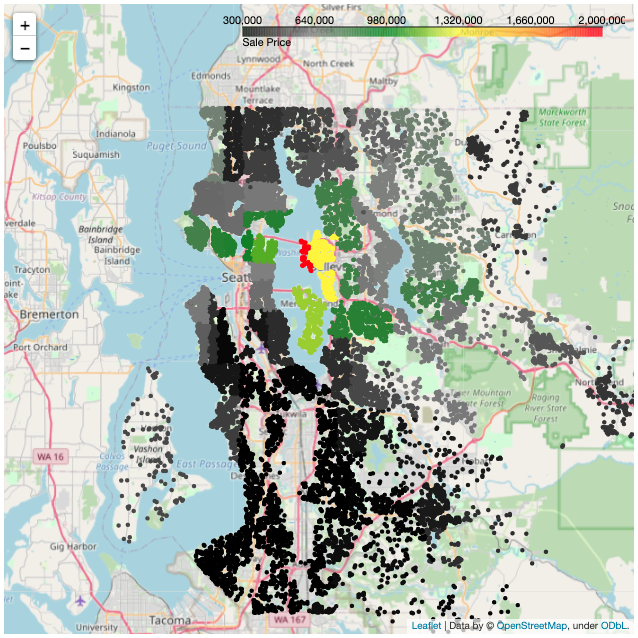

- Note:
    - Feature engineering with data aggregated by zipcode must be done ***AFTER*** the test train split, as we would be using data in these calculations that end up in our test set, and we want to prevent data leakage

## 16) Lat/Long: 
- Location displays a strong trend with sale price!
    - Areas near Lake Washington and Bellevue have very high prices
    - Towards the south-west end of the map prices are significantly lower

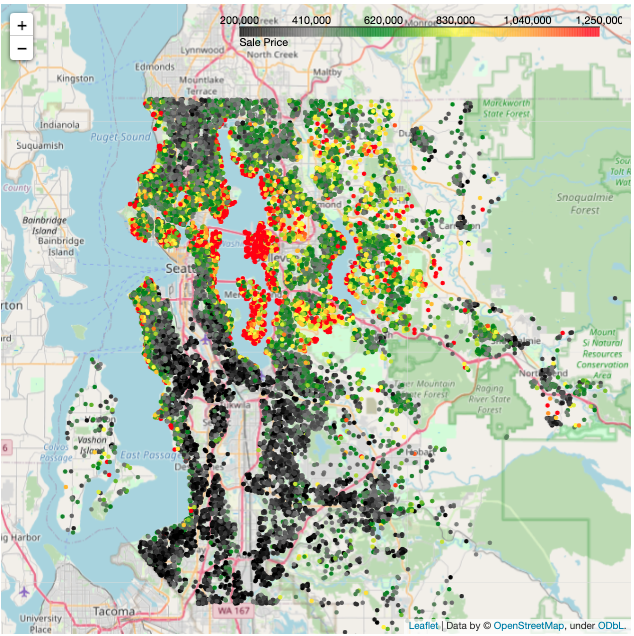

# Interactions
- Interactions refer to when the relationship between one independent variable and the dependent variable differ across a second independent variable
    - Detecting and accounting for interactions can lead to better models
- As we can see below, the relationsip between sqft_living and sale price is heavily influenced by the grade of the house
    - Adding square footage to a lower grade house does not increase the price of the house nearly as much as if we added square footage to a higher quality house

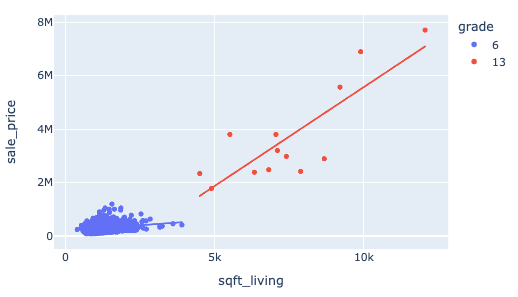

- Additional square footage in a waterfront house raises the price significantly more than addiitonal square footage in a non-waterfront house

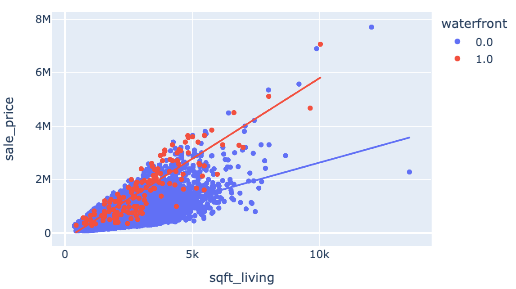

# Declare cleaned dataset for Modelling

In [35]:
# Drop unwanted columns
df_clean = df.loc[:,~df.columns.str.contains('sale_date|sale_id|yr_built')]
df_clean.sample(5)

sale_price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
unique_id                                                                    
1171       359000.0000         3     2.5000         1450      3850  2.0000   
8710       525000.0000         4     2.2500         2660      7957  1.0000   
13536      635000.0000         5     2.2500         2180      6000  1.0000   
20808     1600000.0000         5     3.7500         3570     10125  2.0000   
6612       340000.0000         4     2.5000         2090      4200  2.0000   

           waterfront  has_been_viewed  condition  grade  sqft_no_basement  \
unique_id                                                                    
1171           0.0000           0.0000          3      7              1450   
8710           0.0000           0.0000          4      8              1750   
13536          0.0000           0.0000          4      8              1430   
20808          0.0000           0.0000          3     10              3570   
6612           0.0000           0.0000          3      7              2090   

           sqft_basement  yr_renovated  zipcode     lat      long  \
unique_id                                                           
1171              0.0000        0.0000    98065 47.5318 -121.8500   
8710            910.0000        0.0000    98011 47.7351 -122.1990   
13536           750.0000        0.0000    98007 47.6235 -122.1430   
20808             0.0000        0.0000    98040 47.5639 -122.2230   
6612              0.0000        0.0000    98038 47.3659 -122.0170   

           sqft_living_15_nn  sqft_lot_15_nn  sale_year  sale_month  \
unique_id                                                             
1171                    1970            3748       2015           3   
8710                    1890            8250       2015           4   
13536                   2160            8800       2015           4   
20808                   1760           10125       2014           9   
6612                    2090            4200       2015           3   

           years_since_update  
unique_id                      
1171                  18.0000  
8710                  45.0000  
13536                 56.0000  
20808                  8.0000  
6612                  15.0000

## Multicollinearity
### View Correlations
- If two of our independent variables are highly correlated, the model won't be able to decipher which of them is actually influencing the dependent variable
- Its important to deal with these features so we can interpret our model properly
    - We can drop one of the variables
    - We can combine then into a new feature
    - We can change one of them (shown below)

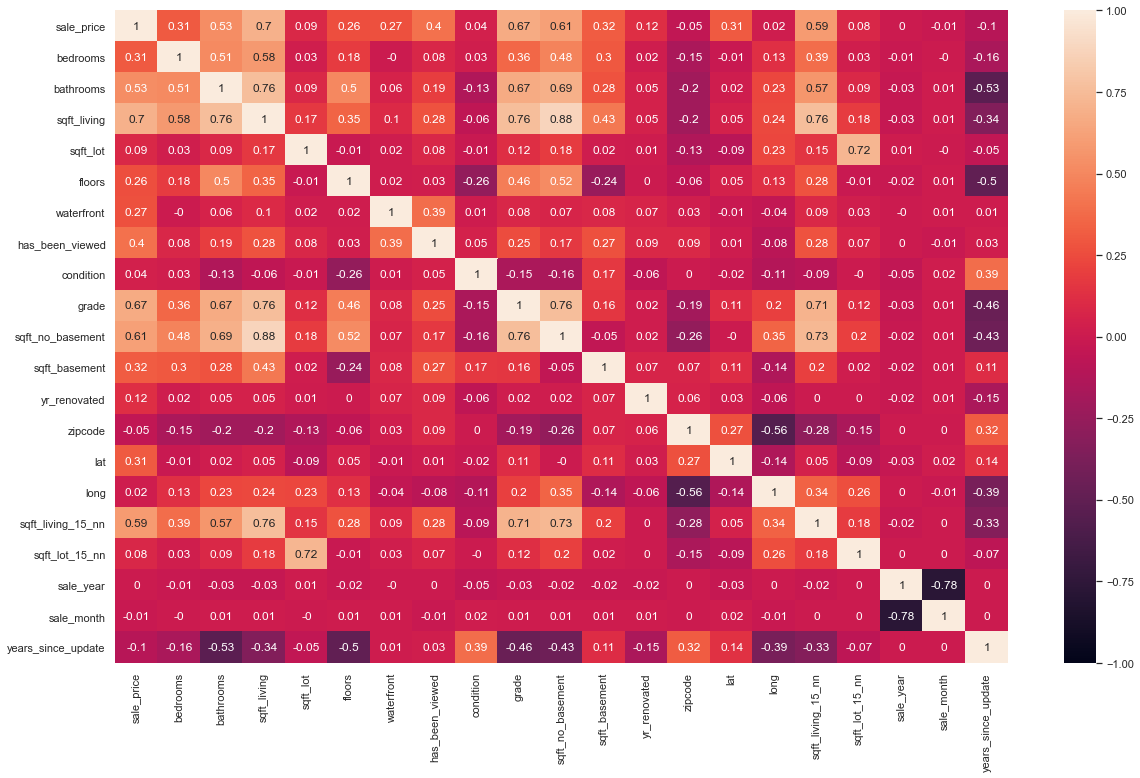

In [36]:
plt.figure(figsize=(20, 12))
heatmap = sns.heatmap(round(df_clean.corr(),2), vmin=-1, vmax=1, annot=True)

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# <center> Modelling </center>

## Approach:
- Only Linear Regression models will be used
    - Assumptions:
        1. Little/no multicollinearity
            - Already handled
        2. Dependent variable is linearly related to independent variables
            - We have observed some non-linear relationships when exploring the data
            - We can add polynomial variable to capture these relationships
        3) Residuals should be independent and normally distributed
            - We have observed non-normal distributions when exploring the data
            - Log transforming these distributions will likely improve results
        4) Homoscedasticity
            - The variance in our errors must be ~ equal across the range of predictions
    - Adhering to these assumptions will result in stronger models and higher confidence interpretations
    

### Modelling   
- Several models will be created, on for each of the following:
    - Baseline
    - Feature Engineering with target variable
    - Log transformations
    - Interactions / polynomials

# 1) Baseline Model

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
# Define independent and dependent variables
X = df_clean.drop(columns='sale_price')
y = df_clean['sale_price']

# Perform first test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [39]:
# Instantiate model and fit to training data
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

LinearRegression()

In [40]:
# Validate Model
train_score = lr1.score(X_train, y_train)
test_score = lr1.score(X_test, y_test)
print(f'Train Score: {round(train_score,3)} \nTest Score: {round(test_score,3)}')

Train Score: 0.7 
Test Score: 0.711


In [41]:
# Get Feature Importances
feature_importances1 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr1.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x)) 

- It appears waterfront and latitude/longitude (location) dominate the importance, followed by grade (quality) and number of views (implicit demand)

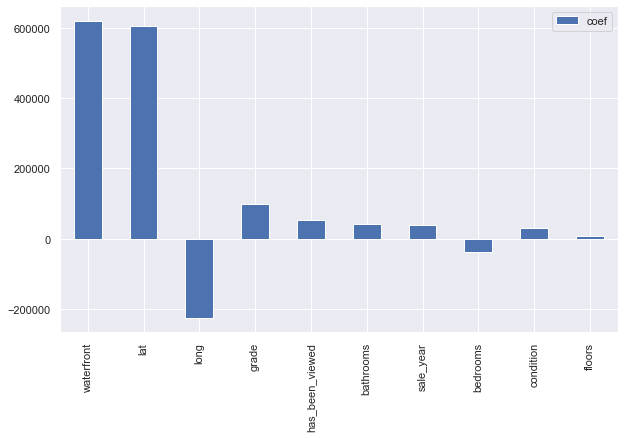

In [42]:
feature_importances1.head(10).plot.bar(figsize=(10,6));

- Our residuals are not perfectly normally distributed, as we have outlier cases in which our model greatly underpredicted the actual sale price

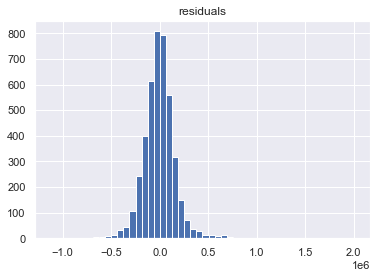

In [43]:
# Plot Residuals
pd.DataFrame({'residuals':(y_test - lr1.predict(X_test))}).hist(bins=50);

# 2) With Additional Feature Engineering

### Feature Engineer with Target Variable:
- Logic:
    - Split data into test and train sets
    - Calculate feature using only the training data
    - Add features to X_train and X_test

In [44]:
def split_and_engineer(cleaned_dataframe):
    '''
    Accepts dataframe
    Returns test and train splits with features engineered using target variable given the random state
    '''
    
    dep_var = 'sale_price' if 'sale_price' in cleaned_dataframe.columns else 'sale_price_log'
    
    # Define independent and dependent variables
    X = cleaned_dataframe.drop(columns=dep_var)
    y = cleaned_dataframe[dep_var]

    # Perform first test/train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8) 

    # Get all train data together
    train_data = cleaned_dataframe.loc[X_train.index,:]

    # Feature engineer
    train_zip_df = pd.DataFrame()
    train_zip_df['num_houses'] = train_data.groupby('zipcode')['zipcode'].count()
    
    if 'sale_price_log' in cleaned_dataframe.columns:
        cols_to_engineer = ['sale_price_log','sqft_living_log','grade_log','years_since_update_log','sqft_lot_log','condition_log','bedrooms_log']
    else:
        cols_to_engineer = ['sale_price','sqft_living','grade','years_since_update','sqft_lot','condition','bedrooms']
    
    for col in cols_to_engineer:
        train_zip_df[f'mean_{col}'] = train_data.groupby('zipcode')[col].mean()

    for col in train_zip_df.columns:
        X_train[f'{col}_in_zip'] = X_train['zipcode'].map(train_zip_df[col].to_dict())    
        X_test[f'{col}_in_zip'] = X_test['zipcode'].map(train_zip_df[col].to_dict())
    
    X_train = X_train.drop(columns='zipcode')
    X_test = X_test.drop(columns='zipcode')

    return X_train, X_test, y_train, y_test

In [45]:
X_train, X_test, y_train, y_test = split_and_engineer(df_clean)

In [46]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train)

LinearRegression()

In [47]:
train_score = lr2.score(X_train, y_train)
test_score = lr2.score(X_test, y_test)
print(f'Train Score: {round(train_score,3)} \nTest Score: {round(test_score,3)}')

Train Score: 0.811 
Test Score: 0.799


In [48]:
# Get Feature Importances
feature_importances2 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr2.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))

- Waterfront is still dominant, followed by location, quality, and demand

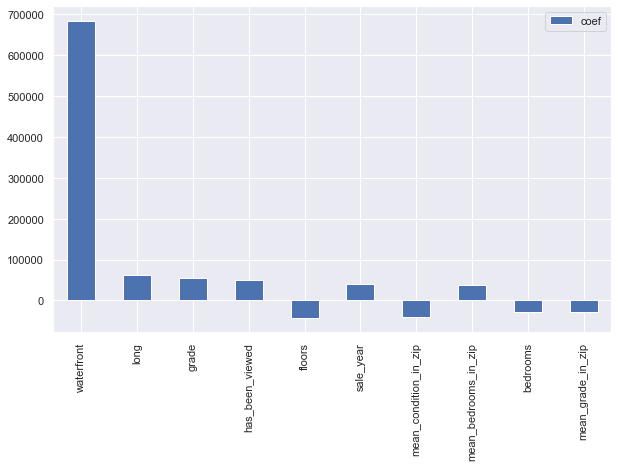

In [49]:
feature_importances2.head(10).plot.bar(figsize=(10,6));

- Residuals are still nor normally distributed
- We need to transform our skewed distributions!

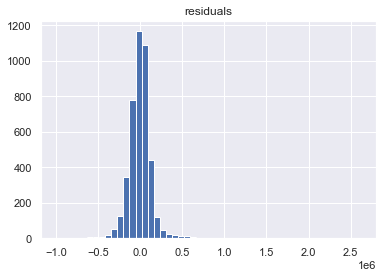

In [50]:
# Plot Residuals
pd.DataFrame({'residuals':(y_test - lr2.predict(X_test))}).hist(bins=50);

# 3) With Feature Normalization

### Log transform features for normality assumption

In [51]:
df_clean_transformed = df_clean.copy()

for col in ['sale_price','bedrooms','sqft_living','sqft_lot','condition','grade','years_since_update','sqft_living_15_nn','sqft_lot_15_nn']:
        df_clean_transformed[f'{col}_log'] = np.log10(df_clean_transformed[col])

df_clean_transformed = df_clean_transformed.drop(columns=[i for i in df_clean_transformed.columns if str(i) + '_log' in df_clean_transformed.columns])

In [52]:
X_train, X_test, y_train, y_test = split_and_engineer(df_clean_transformed)

In [53]:
lr3 = LinearRegression()
lr3.fit(X_train, y_train)

LinearRegression()

In [54]:
train_score = lr3.score(X_train, y_train)
test_score = lr3.score(X_test, y_test)
print(f'Train Score: {round(train_score,3)} \nTest Score: {round(test_score,3)}')

Train Score: 0.886 
Test Score: 0.883


In [55]:
# Get Feature Importances
feature_importances3 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr3.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))

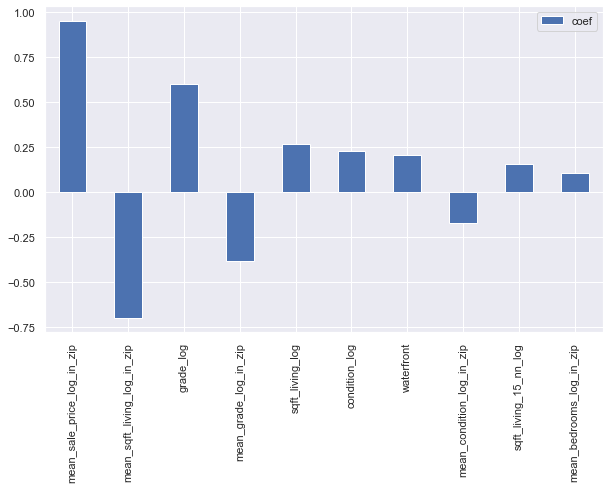

In [56]:
feature_importances3.head(10).plot.bar(figsize=(10,6));

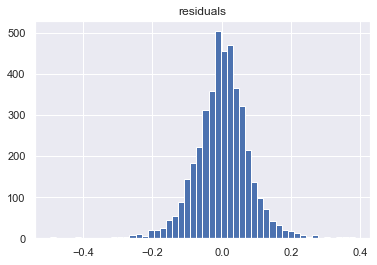

In [57]:
# Plot Residuals
pd.DataFrame({'residuals':(y_test - lr3.predict(X_test))}).hist(bins=50);

# 4) With Feature Scaling

### Log transform features for normality assumption

In [58]:
df_clean_transformed = df_clean.copy()

for col in ['sale_price','bedrooms','sqft_living','sqft_lot','condition','grade','years_since_update','sqft_living_15_nn','sqft_lot_15_nn']:
        df_clean_transformed[f'{col}_log'] = np.log10(df_clean_transformed[col])

df_clean_transformed = df_clean_transformed.drop(columns=[i for i in df_clean_transformed.columns if str(i) + '_log' in df_clean_transformed.columns])

In [59]:
X_train, X_test, y_train, y_test = split_and_engineer(df_clean_transformed)

In [60]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
lr4 = LinearRegression()
lr4.fit(X_train_scaled, y_train)

LinearRegression()

In [62]:
train_score = lr4.score(X_train_scaled, y_train)
test_score = lr4.score(X_test_scaled, y_test)
print(f'Train Score: {round(train_score,3)} \nTest Score: {round(test_score,3)}')

Train Score: 0.886 
Test Score: 0.883


In [63]:
# Get Feature Importances
feature_importances4 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr4.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))

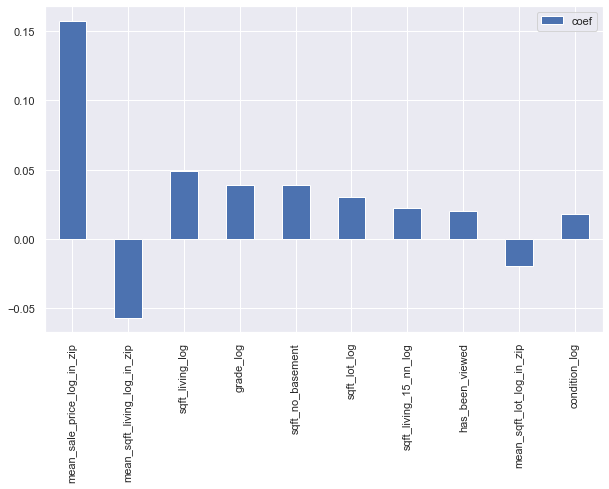

In [64]:
feature_importances4.head(10).plot.bar(figsize=(10,6));

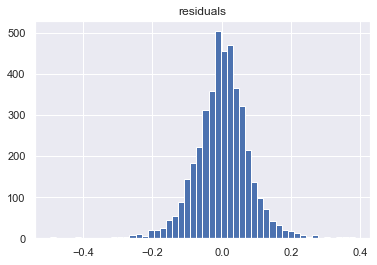

In [65]:
# Plot Residuals
pd.DataFrame({'residuals':(y_test - lr4.predict(X_test_scaled))}).hist(bins=50);

# 5) Interactions and Polynomials

In [66]:
X_train, X_test, y_train, y_test = split_and_engineer(df_clean_transformed)

In [67]:
cols_to_include = X_train.columns

for i1, col1 in enumerate(cols_to_include):
    X_train[f'{col1}_^2'] = X_train[col1]**2
    X_test[f'{col1}_^2'] = X_test[col1]**2
    for col2 in cols_to_include[i1+1:]:
        X_train[f'{col1}_x_{col2}'] = X_train[col1] * X_train[col2]
        X_test[f'{col1}_x_{col2}'] = X_test[col1] * X_test[col2]

In [68]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
lr5 = LinearRegression()
lr5.fit(X_train_scaled, y_train)

LinearRegression()

In [70]:
train_score = lr5.score(X_train_scaled, y_train)
test_score = lr5.score(X_test_scaled, y_test)
print(f'Train Score: {round(train_score,3)} \nTest Score: {round(test_score,3)}')

Train Score: 0.904 
Test Score: 0.895


In [71]:
# Get Feature Importances
feature_importances5 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr5.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))

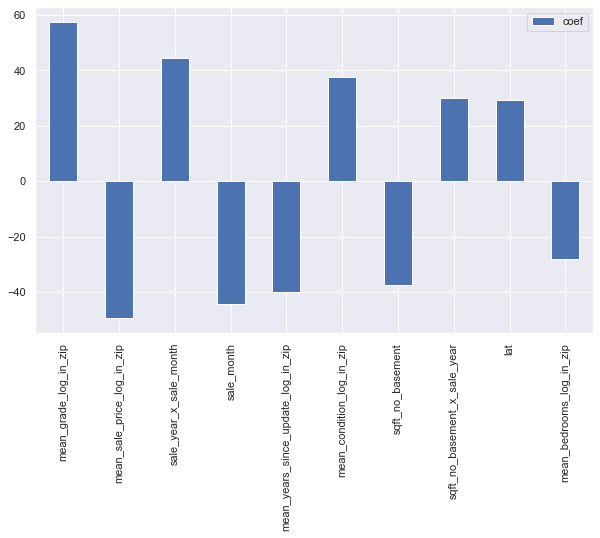

In [72]:
feature_importances5.head(10).plot.bar(figsize=(10,6));

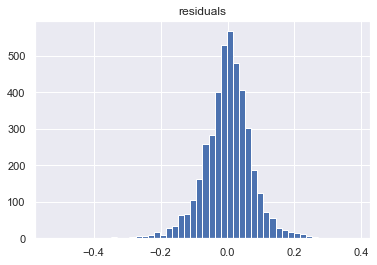

In [73]:
# Plot Residuals
pd.DataFrame({'residuals':(y_test - lr5.predict(X_test_scaled))}).hist(bins=50);

## Model Recap:
- 5 Models built
    1) Baseline model:
        - Achieved ~71% accuracy
        - Residuals were not normally distributed (problem)
    2) Extra Feature Engineering Model:
        - Achieved ~80% accuracy (+9% uplift)
        - Residuals not normally distributed (problem)
    3) With Feature Normalization:
        - Achieved 88% accuracy (+8% uplift)
        - Residuals were normally distributed
        - Also had the extra engineer features
    4) With Feature Scaling:
        - Achieved 88% accuracy (+0% uplift)
        - Feature Importances changed
        - Residuals were normally distributed
        - * Also had the extra engineer features
    5) With Interactions and Polynomials:
        - Achieved 89.5% accuracy (+ 1.5% uplift)
        - Also had normalized and extra engineer features

## Model Interpretation:
- Model 5 had the highest score by 1.5%, however it introduced 385 additional features
- This is a common tradeoff between model complexity and interpretability
- Model 4 will be chosen as the model to continue with becuase it strikes the right balance of performance and clarity

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# 1) Iteratively drop features

In [74]:
# Feature Normalization
df_clean_transformed = df_clean.copy()

for col in ['sale_price','bedrooms','sqft_living','sqft_lot','condition','grade','years_since_update','sqft_living_15_nn','sqft_lot_15_nn']:
        df_clean_transformed[f'{col}_log'] = np.log10(df_clean_transformed[col])

df_clean_transformed = df_clean_transformed.drop(columns=[i for i in df_clean_transformed.columns if str(i) + '_log' in df_clean_transformed.columns])

In [75]:
n_features = []
scores = []

while df_clean_transformed.shape[1] > 5:

    # Test Train Split
    X_train, X_test, y_train, y_test = split_and_engineer(df_clean_transformed)

    # Feature Scaling
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)

    lr4 = LinearRegression()
    lr4.fit(X_train_scaled, y_train)

    # Get Feature Importances
    feature_importances4 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr4.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))
    least_important_feature = feature_importances4.index[-1]
    
    
    

KeyboardInterrupt: 

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

### Recreate model # 4

In [ ]:
# Feature Normalization
df_clean_transformed = df_clean.copy()

for col in ['sale_price','bedrooms','sqft_living','sqft_lot','condition','grade','years_since_update','sqft_living_15_nn','sqft_lot_15_nn']:
        df_clean_transformed[f'{col}_log'] = np.log10(df_clean_transformed[col])

df_clean_transformed = df_clean_transformed.drop(columns=[i for i in df_clean_transformed.columns if str(i) + '_log' in df_clean_transformed.columns])

In [ ]:
# Test Train Split
X_train, X_test, y_train, y_test = split_and_engineer(df_clean_transformed)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)

In [ ]:
lr4 = LinearRegression()
lr4.fit(X_train_scaled, y_train)

In [ ]:
# Get Feature Importances
feature_importances4 = pd.DataFrame(index=X_train.columns,columns=['coef'], data=lr4.coef_).sort_values('coef',ascending=False, key=lambda x: abs(x))

In [ ]:
feature_importances4.plot.bar(figsize=(20,6));

### Get predictions, actuals, residuals

In [ ]:
train = pd.concat([X_train,X_test])
train_scaled = pd.concat([X_train_scaled,X_test_scaled])

In [ ]:
comparison_df = train.copy()
comparison_df['Prediction_log'] = lr4.predict(train_scaled)
comparison_df['Prediction'] = 10**comparison_df['Prediction_log']
comparison_df['Actual'] = y
comparison_df['Residual'] = comparison_df['Prediction'] - comparison_df['Actual']

### Plot predictions vs actuals

- As we can see in the plot below, we do see some heterscedasticity!
- There tends to be more error on the higher end of sale price
- Our dataset is significantly more sparse in this range

In [ ]:
fig = px.scatter(comparison_df, 
                 x='Prediction', 
                 y='Actual', 
                 trendline="ols",
                 color='Residual',
                 color_continuous_scale='portland',
                 title='Model Prediction Price vs Actual Price',
                 height = 400,
                 width = 700
                )
fig.show()

### Map Residuals

- Looking at model errors in map view we can see they are not totally randomly distributed
- There are clusters of errors close together, which hints that there is something about those clusters the model is not capturin
    - This could be something about the build or maybe a location feature

In [ ]:
# Create map
map_visual = folium.Map(location=(comparison_df['lat'].mean(), comparison_df['long'].mean()), zoom_star = 9, width = 800, height = 800)

# Specify feature to color by
color_by = 'Residual'

# Create color map
colormap = cm.LinearColormap(colors=['red','red','white','red','red'], vmin=-2000000, vmax= 2000000)

# Loop through each home in set, create circle, add to map.
for idx in comparison_df.index:
    folium.Circle(
        location=[comparison_df.loc[idx]['lat'], comparison_df.loc[idx]['long']],
        radius = 20,
        fill=True,
        color = colormap(comparison_df.loc[idx][color_by]),
    
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Sale Price'
map_visual.add_child(colormap)

# View
map_visual

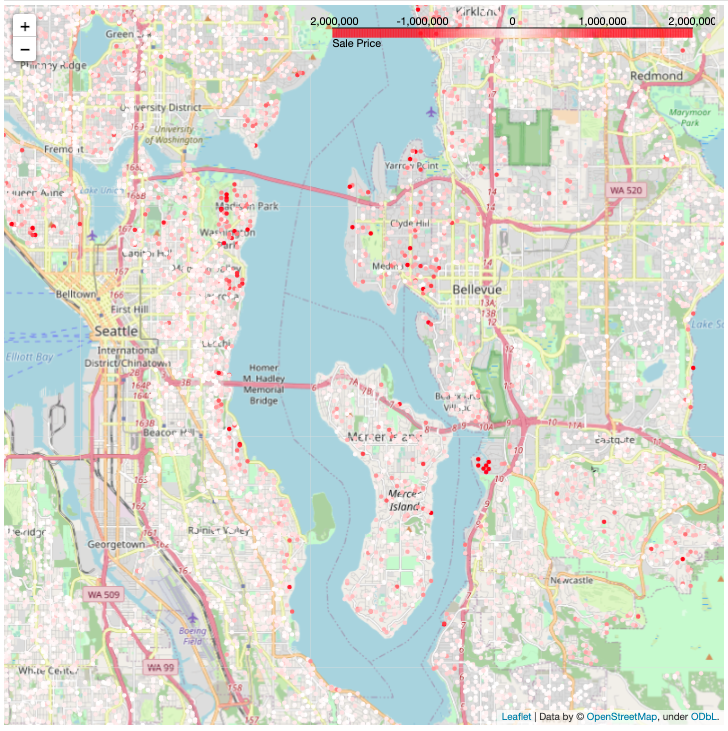

# Forward:
- Due to the heterscedasticity it might be a good idea to create more than one model
    - Creating a model solely for houses above ~ $3 million might lead to more promising results at higher sale prices
- The non-random geospatial errors hint that there are likely other location based features that need to be provided to the model